/nix/store/4x5djgl2fis16a5sfi9cwj7pri065cbb-python3-3.6.5-env/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/nix/store/4x5djgl2fis16a5sfi9cwj7pri065cbb-python3-3.6.5-env/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


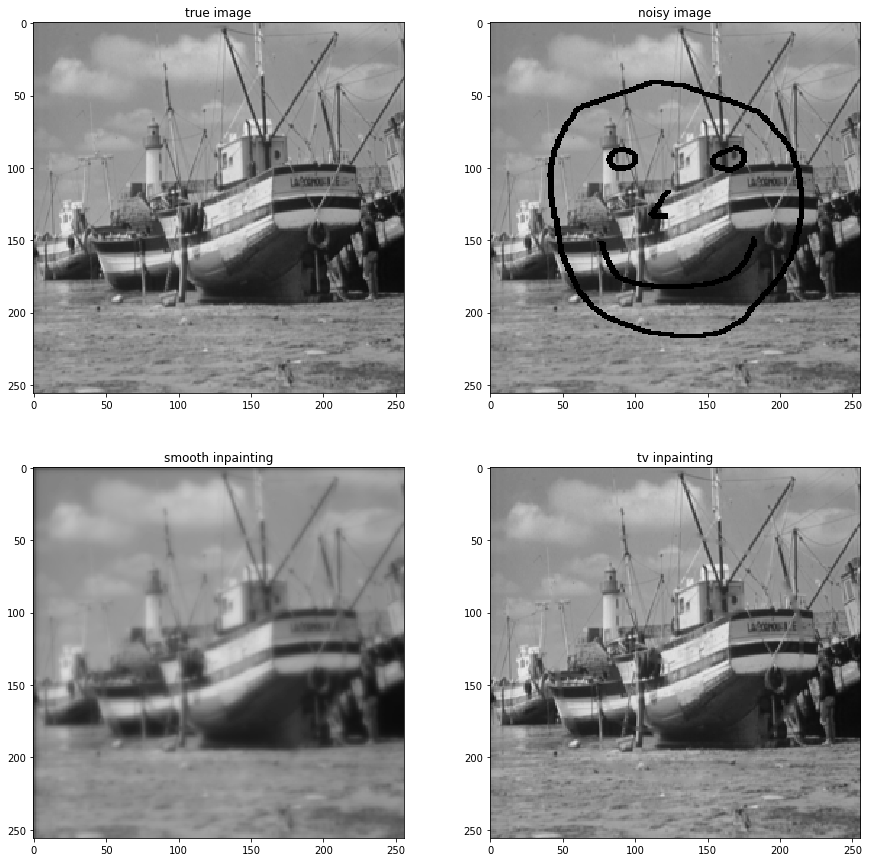

In [6]:
%matplotlib inline

import numpy as np
import scipy.linalg
import scipy.misc
import scipy.io
import scipy.sparse as sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt


alphaTV = 3e-3;  # regularization parameter for \|grad u\|_{L^2}^2 penalty
alpha = 3e-5;  # regularization parameter for \|grad u\|_{L^2}^2 penalty
beta = 1.5e8;   # regularization parameter for |u|_TV penalty

damage=scipy.io.loadmat('damaged_pixel_ind.mat',struct_as_record=True)

#im = scipy.misc.imread('house.png')
#ind_damaged=damage['ind'][0, 0]['scratches256']

#Alternatively try
im = scipy.misc.imread('boat.png')
im=scipy.misc.imresize(im,(256,256))
ind_damaged=damage['ind'][0, 0]['smily256']

# add noise
[ny,nx] = im.shape
gdelta = im*1.0
gdelta.ravel('F')[ind_damaged]=0
gdelta[np.unravel_index(ind_damaged, gdelta.shape, 'F')]=0

def imageSobInpainting(im,alpha,dam):
    [ny,nx] = im.shape
    # create matrix dx approximating partial derivative w.r.t. x 
    # by forward finite differences
    aux_dx = nx*np.stack((-np.ones(nx),np.ones(nx)),axis=0)
    dx = sparse.kron(sparse.spdiags(aux_dx,[0, 1],nx,nx),sparse.eye(ny))
    # create matrix dy approximating partial derivative w.r.t. y
    # by forward finite differences
    aux_dy = ny*np.stack((-np.ones(ny),np.ones(ny)),axis=0)
    dy = sparse.kron(sparse.eye(nx),sparse.spdiags(aux_dy,[0, 1],ny,ny))
    # matrix approximating the divergence operator
    Div =sparse.hstack([dx,dy])
        
    Bd=np.ones(nx*ny)
    Bd[dam]=0

    # note that Div*Div'  = - Div*Grad = - Laplace 
    rec_Sobo = sparse.linalg.spsolve((sparse.spdiags(Bd,0,nx*ny,nx*ny)+ alpha*Div@Div.transpose()),im.ravel('F'))
    return np.reshape(rec_Sobo,(ny,nx),'F')


def imageTvInpainting(im,alpha,beta,dam):
     # create matrix dx approximating partial derivative w.r.t. x 
    # by forward finite differences
    aux_dx = nx*np.stack((-np.ones(nx),np.ones(nx)),axis=0)
    dx = sparse.kron(sparse.spdiags(aux_dx,[0, 1],nx,nx),sparse.eye(ny))
    # create matrix dy approximating partial derivative w.r.t. y
    # by forward finite differences
    aux_dy = ny*np.stack((-np.ones(ny),np.ones(ny)),axis=0)
    dy = sparse.kron(sparse.eye(nx),sparse.spdiags(aux_dy,[0, 1],ny,ny))
    # matrix approximating the divergence operator
    Div =sparse.hstack([dx,dy])
    
    # initialize
    p=np.zeros(2*nx*ny)
    k_max=2000
    step=np.zeros(k_max)
    # Chambolle Algorithm
    Bd=np.ones(nx*ny)
    Bd[dam]=1/alpha
    B=sparse.spdiags(Bd,0,nx*ny,nx*ny)
    # determine stepsize
    ev_max=sparse.linalg.eigsh(Div.transpose()@B@Div,1,return_eigenvectors=False)
    tau=1./(ev_max+1)   
    for k in range(k_max):
        inter=-Div.transpose()@B@(Div@p+im.ravel('F'))
        internorm=np.array([(inter[0:nx*ny]**2+inter[nx*ny:]**2)**0.5,(inter[0:nx*ny]**2+inter[nx*ny:]**2)**0.5]).ravel()
        pnew=(p+tau*inter)/(1+(tau/beta)*internorm)
        step[k]=np.linalg.norm(p-pnew)
        p=pnew
    rec_tv = B@(Div@p+im.ravel('F'))
    rec_tv = np.reshape(rec_tv,(ny,nx),'F')
    return rec_tv
    





plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(im, cmap='gray',vmin=0, vmax=255)
plt.title('true image')

plt.subplot(2,2,2)
plt.imshow(gdelta, cmap='gray',vmin=0, vmax=255)
plt.title('noisy image')

plt.subplot(2,2,3)
plt.imshow(imageSobInpainting(gdelta,alpha,ind_damaged), cmap='gray',vmin=0, vmax=255)
plt.title('smooth inpainting')

plt.subplot(2,2,4)
plt.imshow(imageTvInpainting(gdelta,alpha,beta,ind_damaged), cmap='gray',vmin=0, vmax=255)
plt.title('tv inpainting')

plt.show()

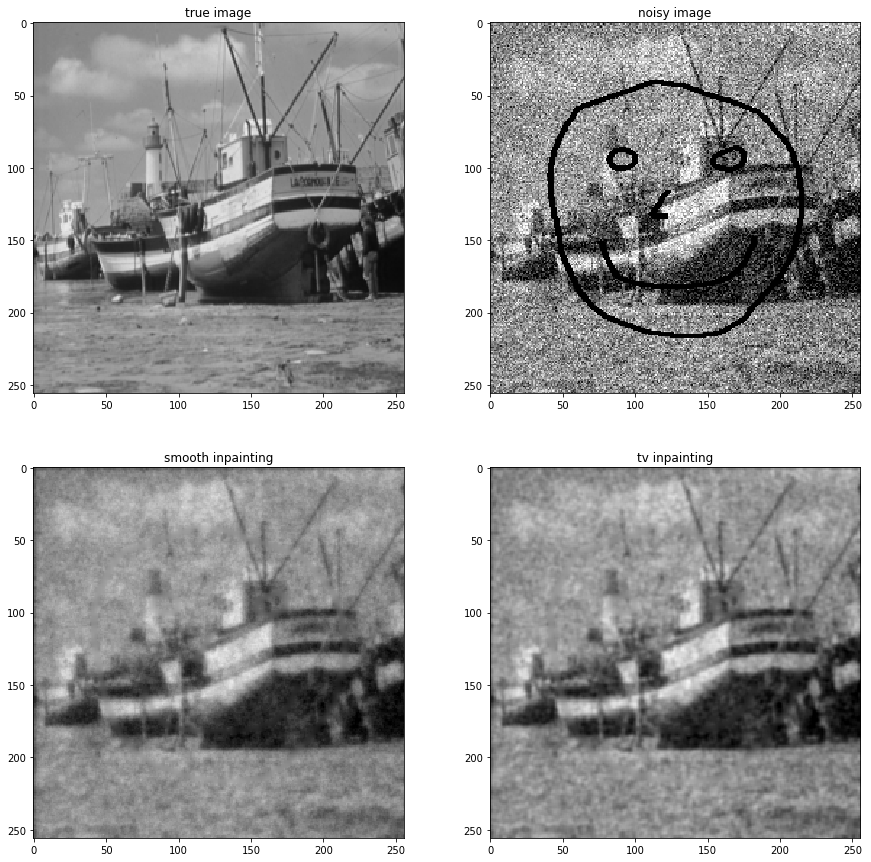

In [12]:
alphaTV = 3e-3;  # regularization parameter for \|grad u\|_{L^2}^2 penalty
alpha = 3e-5;  # regularization parameter for \|grad u\|_{L^2}^2 penalty
beta = 1.5e9;   # regularization parameter for |u|_TV penalty

gdelta = im*1.0+ 40*np.random.randn(nx,ny)
gdelta.ravel('F')[ind_damaged]=0
gdelta[np.unravel_index(ind_damaged, gdelta.shape, 'F')]=0

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(im, cmap='gray',vmin=0, vmax=255)
plt.title('true image')

plt.subplot(2,2,2)
plt.imshow(gdelta, cmap='gray',vmin=0, vmax=255)
plt.title('noisy image')

plt.subplot(2,2,3)
plt.imshow(imageSobInpainting(gdelta,alpha,ind_damaged), cmap='gray',vmin=0, vmax=255)
plt.title('smooth inpainting')

plt.subplot(2,2,4)
plt.imshow(imageTvInpainting(gdelta,alphaTV,beta,ind_damaged), cmap='gray',vmin=0, vmax=255)
plt.title('tv inpainting')

plt.show()